## Introduction

In this notebook, we conduct an end‑to‑end analysis of the **BankChurners** dataset (15 numerical & 8 categorical features) to understand and predict customer attrition in a competitive banking environment. Our objectives are to:

1. **Define the problem** — quantify the impact of high churn (revenue loss, weakened brand loyalty, costly replacements).  
2. **Prepare the data** — remove irrelevant columns, handle outliers via IQR, and convert `Attrition_Flag` into a binary `Churn` label.  
3. **Explore patterns (EDA)** — visualise distributions and joint relationships across demographics, transaction volume, utilisation ratios, and tenure.  
4. **Rank features** — use correlation, F‑score (ANOVA), and mutual information to identify top predictors such as `Total_Trans_Ct`, `Total_Trans_Amt`, and `Avg_Utilization_Ratio`.  
5. **Build models** — train and compare Logistic Regression, Decision Tree, Random Forest, AdaBoost, XGBoost, SVM, and MLP to find the best churn‑prediction engine.  
6. **Derive insights & actions** — translate model outputs into targeted retention strategies (workshops, credit‑rebuilding, personalised perks).


## 1. Setup

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import matplotlib.patches as mpatches
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, roc_curve, roc_auc_score,
                             precision_recall_fscore_support)


plt.rcParams['figure.figsize'] = (10, 6)

import warnings
warnings.filterwarnings('ignore')

print("Setup complete.")

Setup complete.


## 2. Data Loading

Ensure the **BankChurners.csv** file is in the same directory as this notebook.

In [ ]:
# Load the dataset
df = pd.read_csv("BankChurners.csv")

# Display the first 5 rows
df.head()

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
0              39  ...       12691.0                  777          11914.0   
1              44  ...        8256.0                  864           7392.0   
2              36  ...        3418.0                    0           3418.0   
3              34  ...        3313.0                 2517            796.0   
4              21  ...        4716.0                    0           4716.0   

   Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0                 1.335             1144              42                1.625   
1                 1.541             1291              33                3.714   
2                 2.594             1887              20                2.333   
3                 1.405             1171              20                2.333   
4                 2.175              816              28                2.500   

   Avg_Utilization_Ratio  \
0                  0.061   
1                  0.105   
2                  0.000   
3                  0.760   
4                  0.000   

   Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1  \
0                                           0.000093                                                                                    
1                                           0.000057                                                                                    
2                                           0.000021                                                                                    
3                                           0.000134                                                                                    
4                                           0.000022                                                                                    

   Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2  
0                                            0.99991                                                                                   
1                                            0.99994                                                                                   
2                                            0.99998                                                                                   
3                                            0.99987                                                                                   
4                                            0.99998                                                                                   

[5 rows x 23 columns]

## 3. Data Cleaning

### 3.1 Drop Unwanted Columns

We remove the following columns:
- `CLIENTNUM`
- Any columns generated by a Naive Bayes model (i.e., those starting with `Naive_Bayes_Classifier_...`)

In [ ]:
# Define columns to drop
columns_to_drop = [
    'CLIENTNUM',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
    'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'
]

# Drop the specified columns
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

print("Columns removed.")
df.head()

Columns removed.


Attrition_Flag  Customer_Age Gender  Dependent_count Education_Level  \
0  Existing Customer            45      M                3     High School   
1  Existing Customer            49      F                5        Graduate   
2  Existing Customer            51      M                3        Graduate   
3  Existing Customer            40      F                4     High School   
4  Existing Customer            40      M                3      Uneducated   

  Marital_Status Income_Category Card_Category  Months_on_book  \
0        Married     $60K - $80K          Blue              39   
1         Single  Less than $40K          Blue              44   
2        Married    $80K - $120K          Blue              36   
3        Unknown  Less than $40K          Blue              34   
4        Married     $60K - $80K          Blue              21   

   Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0                         5                       1                      3   
1                         6                       1                      2   
2                         4                       1                      0   
3                         3                       4                      1   
4                         5                       1                      0   

   Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0       12691.0                  777          11914.0                 1.335   
1        8256.0                  864           7392.0                 1.541   
2        3418.0                    0           3418.0                 2.594   
3        3313.0                 2517            796.0                 1.405   
4        4716.0                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1144              42                1.625                  0.061  
1             1291              33                3.714                  0.105  
2             1887              20                2.333                  0.000  
3             1171              20                2.333                  0.760  
4              816              28                2.500                  0.000

### 3.2 Checking for Missing Values

We check for any missing values that might need to be addressed.

In [ ]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values in each column:")
print(missing_values)

Missing Values in each column:
Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64


### 3.3 Create Numeric `Churn` Column

We keep the original `Attrition_Flag` for distribution plots. Then we create a numeric `Churn` column:
- `Existing Customer` → 0
- `Attrited Customer` → 1

In [ ]:
# Map 'Attrition_Flag' to a binary numeric column 'Churn'
df['Churn'] = df['Attrition_Flag'].map({'Existing Customer': 0, 'Attrited Customer': 1})

print("Unique values in Attrition_Flag:", df['Attrition_Flag'].unique())
print("Churn column created.")
df[['Attrition_Flag', 'Churn']].head()

Unique values in Attrition_Flag: ['Existing Customer' 'Attrited Customer']
Churn column created.


Attrition_Flag  Churn
0  Existing Customer      0
1  Existing Customer      0
2  Existing Customer      0
3  Existing Customer      0
4  Existing Customer      0

## 4. Exploratory Data Analysis (EDA)

### 4.1 Distribution of `Attrition_Flag`

We examine how many customers are attrited vs. existing.

Attrition_Flag
Existing Customer    8500
Attrited Customer    1627
Name: count, dtype: int64


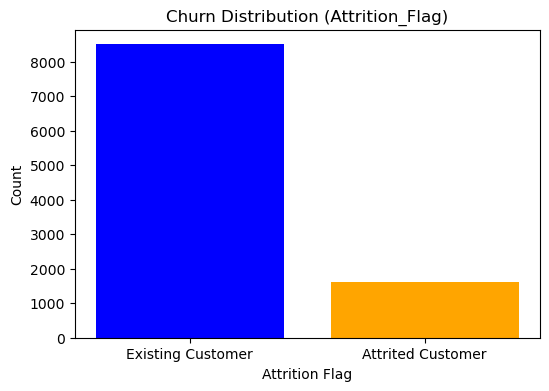

In [ ]:
# Check distribution of Attrition_Flag
if 'Attrition_Flag' in df.columns:
    churn_counts = df['Attrition_Flag'].value_counts()
    print(churn_counts)

    # Bar plot
    plt.figure(figsize=(6,4))
    plt.bar(churn_counts.index, churn_counts.values, color=['blue','orange'])
    plt.title('Churn Distribution (Attrition_Flag)')
    plt.xlabel('Attrition Flag')
    plt.ylabel('Count')
    plt.show()
else:
    print("'Attrition_Flag' column not found.")

### 4.2 Outlier Removal

We remove outliers from all numeric columns **except** for `Churn`, using the IQR method.

In [ ]:
# Create a copy for outlier removal
df_clean = df.copy()

# Identify numeric columns, excluding 'Churn'
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
if 'Churn' in numeric_cols:
    numeric_cols.remove('Churn')

# Remove outliers using IQR
for col in numeric_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

print("Original shape:", df.shape)
print("Cleaned shape:", df_clean.shape)

# Update df to the cleaned version
df = df_clean.copy()

Original shape: (10127, 21)
Cleaned shape: (6463, 21)


### 4.3 Data Overview (Post-Cleaning)

In [ ]:
# View basic info after cleaning
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6463 entries, 10 to 10125
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            6463 non-null   object 
 1   Customer_Age              6463 non-null   int64  
 2   Gender                    6463 non-null   object 
 3   Dependent_count           6463 non-null   int64  
 4   Education_Level           6463 non-null   object 
 5   Marital_Status            6463 non-null   object 
 6   Income_Category           6463 non-null   object 
 7   Card_Category             6463 non-null   object 
 8   Months_on_book            6463 non-null   int64  
 9   Total_Relationship_Count  6463 non-null   int64  
 10  Months_Inactive_12_mon    6463 non-null   int64  
 11  Contacts_Count_12_mon     6463 non-null   int64  
 12  Credit_Limit              6463 non-null   float64
 13  Total_Revolving_Bal       6463 non-null   int64  
 14  Avg_Open_To

In [ ]:
# Summary statistics (including categorical columns)
df.describe(include='all')

Attrition_Flag  Customer_Age Gender  Dependent_count  \
count                6463   6463.000000   6463      6463.000000   
unique                  2           NaN      2              NaN   
top     Existing Customer           NaN      F              NaN   
freq                 5380           NaN   3988              NaN   
mean                  NaN     46.384032    NaN         2.389138   
std                   NaN      7.506139    NaN         1.272785   
min                   NaN     26.000000    NaN         0.000000   
25%                   NaN     41.000000    NaN         1.000000   
50%                   NaN     46.000000    NaN         2.000000   
75%                   NaN     52.000000    NaN         3.000000   
max                   NaN     68.000000    NaN         5.000000   

       Education_Level Marital_Status Income_Category Card_Category  \
count             6463           6463            6463          6463   
unique               7              4               6             4   
top           Graduate        Married  Less than $40K          Blue   
freq              2006           2994            2677          6341   
mean               NaN            NaN             NaN           NaN   
std                NaN            NaN             NaN           NaN   
min                NaN            NaN             NaN           NaN   
25%                NaN            NaN             NaN           NaN   
50%                NaN            NaN             NaN           NaN   
75%                NaN            NaN             NaN           NaN   
max                NaN            NaN             NaN           NaN   

        Months_on_book  Total_Relationship_Count  ...  Contacts_Count_12_mon  \
count      6463.000000               6463.000000  ...            6463.000000   
unique             NaN                       NaN  ...                    NaN   
top                NaN                       NaN  ...                    NaN   
freq               NaN                       NaN  ...                    NaN   
mean         35.951106                  3.939192  ...               2.497138   
std           7.036630                  1.514048  ...               0.930392   
min          18.000000                  1.000000  ...               1.000000   
25%          32.000000                  3.000000  ...               2.000000   
50%          36.000000                  4.000000  ...               3.000000   
75%          40.000000                  5.000000  ...               3.000000   
max          53.000000                  6.000000  ...               4.000000   

        Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
count    6463.000000          6463.000000      6463.000000   
unique           NaN                  NaN              NaN   
top              NaN                  NaN              NaN   
freq             NaN                  NaN              NaN   
mean     5084.608170          1140.233792      3944.374377   
std      3921.874545           817.255076      3934.216696   
min      1438.300000             0.000000        10.000000   
25%      2264.000000             0.000000      1018.000000   
50%      3359.000000          1250.000000      2229.000000   
75%      6841.000000          1766.500000      5712.500000   
max     19099.000000          2517.000000     16582.000000   

        Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
count            6463.000000      6463.000000     6463.000000   
unique                   NaN              NaN             NaN   
top                      NaN              NaN             NaN   
freq                     NaN              NaN             NaN   
mean                0.728738      3593.651710       62.892155   
std                 0.162697      1568.378776       19.472826   
min                 0.293000       510.000000       10.000000   
25%                 0.620000      2216.000000       46.000000   
50%                 0.721000      3908.000000       67.000000 

### 4.4 Categorical Analysis

We analyze the average churn rate for key categorical variables.

=== Analysis for Gender ===
Churn Rate by Category:
Gender
F    0.178536
M    0.149899
Name: Churn, dtype: float64

Chi-square statistic: 8.7742
p-value: 0.0031
Degrees of freedom: 1
--------------------------------------------------


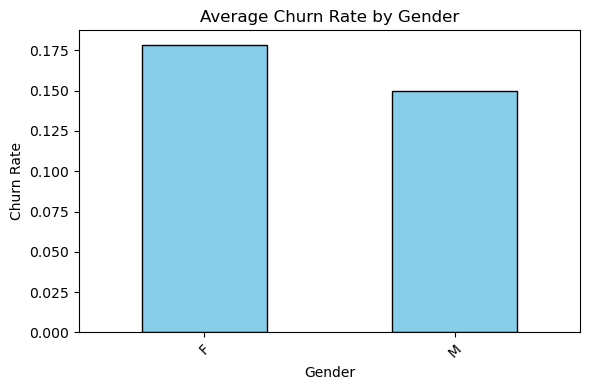

=== Analysis for Education_Level ===
Churn Rate by Category:
Education_Level
College          0.158133
Doctorate        0.230769
Graduate         0.166002
High School      0.148148
Post-Graduate    0.195652
Uneducated       0.164871
Unknown          0.177215
Name: Churn, dtype: float64

Chi-square statistic: 15.0267
p-value: 0.0201
Degrees of freedom: 6
--------------------------------------------------


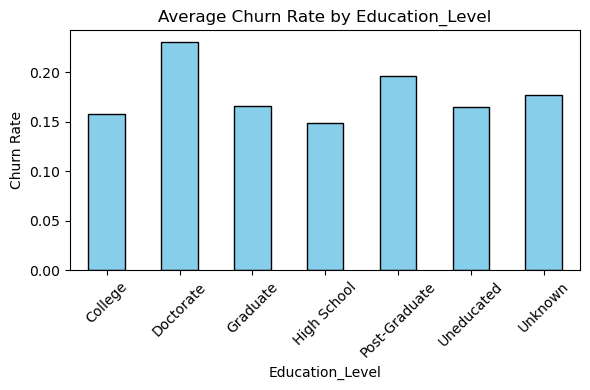

=== Analysis for Marital_Status ===
Churn Rate by Category:
Marital_Status
Divorced    0.173362
Married     0.163995
Single      0.168526
Unknown     0.179012
Name: Churn, dtype: float64

Chi-square statistic: 0.8607
p-value: 0.8349
Degrees of freedom: 3
--------------------------------------------------


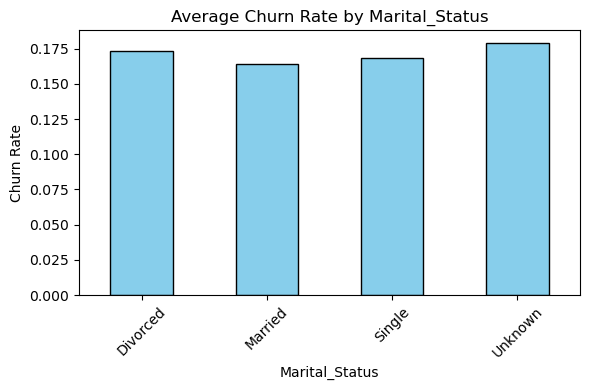

=== Analysis for Income_Category ===
Churn Rate by Category:
Income_Category
$120K +           0.181818
$40K - $60K       0.158631
$60K - $80K       0.140199
$80K - $120K      0.168539
Less than $40K    0.178558
Unknown           0.167131
Name: Churn, dtype: float64

Chi-square statistic: 7.7728
p-value: 0.1692
Degrees of freedom: 5
--------------------------------------------------


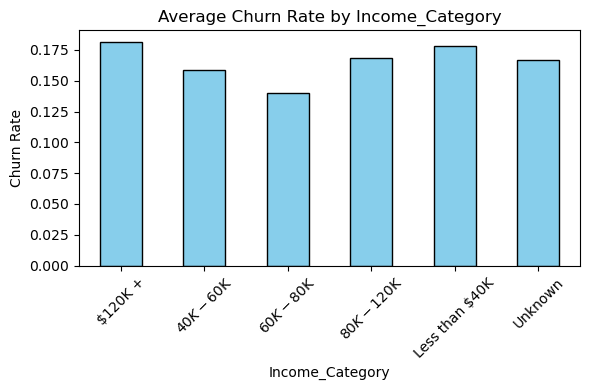

=== Analysis for Card_Category ===
Churn Rate by Category:
Card_Category
Blue        0.167955
Gold        0.187500
Platinum    0.666667
Silver      0.126214
Name: Churn, dtype: float64

Chi-square statistic: 6.6725
p-value: 0.0831
Degrees of freedom: 3
--------------------------------------------------


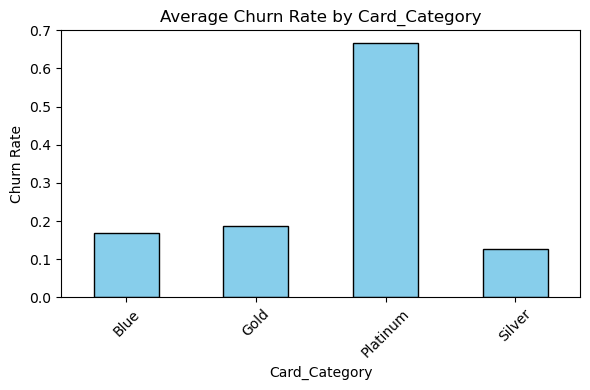

In [ ]:
categorical_cols = ["Gender", "Education_Level", "Marital_Status", "Income_Category", "Card_Category"]

for col in categorical_cols:
    if col in df.columns:
        print(f"=== Analysis for {col} ===")
        churn_rate = df.groupby(col)['Churn'].mean()
        print("Churn Rate by Category:")
        print(churn_rate)

        # Optional: Chi-square test
        contingency_table = pd.crosstab(df[col], df['Churn'])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        print(f"\nChi-square statistic: {chi2:.4f}")
        print(f"p-value: {p:.4f}")
        print(f"Degrees of freedom: {dof}")
        print("-" * 50)

        # Plot bar chart
        plt.figure(figsize=(6, 4))
        churn_rate.plot(kind='bar', color='skyblue', edgecolor='black')
        plt.title(f"Average Churn Rate by {col}")
        plt.ylabel("Churn Rate")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Column {col} not found in DataFrame.")

### 4.5 Numerical Feature Distributions

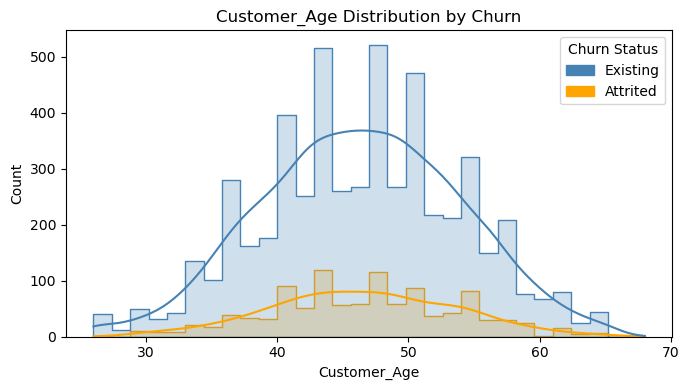

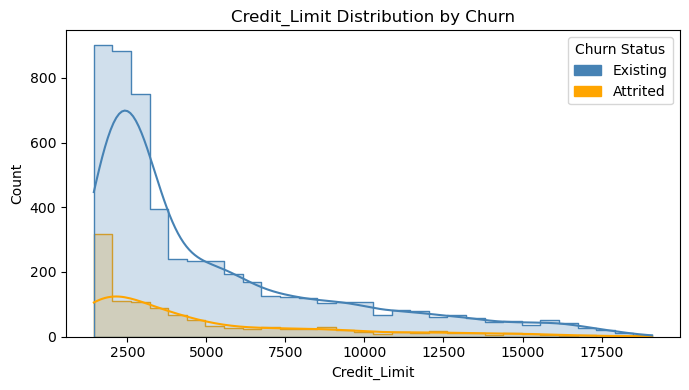

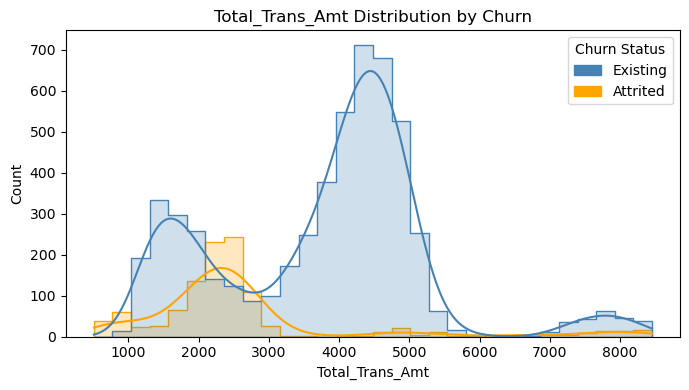

In [ ]:
import matplotlib.patches as mpatches

numeric_cols = ["Customer_Age", "Credit_Limit", "Total_Trans_Amt"]

# Define custom legend patches
attrited_patch = mpatches.Patch(color='orange', label='Attrited')
existing_patch = mpatches.Patch(color='steelblue', label='Existing')

for col in numeric_cols:
    if col in df.columns:
        plt.figure(figsize=(7, 4))
        sns.histplot(
            data=df, 
            x=col, 
            hue='Churn', 
            kde=True, 
            bins=30, 
            palette={1: 'orange', 0: 'steelblue'}, 
            element='step'
        )
        plt.title(f'{col} Distribution by Churn')
        plt.xlabel(col)
        plt.ylabel('Count')

        # Custom legend
        plt.legend(
            handles=[existing_patch, attrited_patch],
            title='Churn Status',
            loc='upper right'
        )

        plt.tight_layout()
        plt.show()
    else:
        print(f"Column {col} not found.")


### 4.6 Correlation Analysis

We compute the correlation matrix for numeric features and display the values in an annotated heatmap.

Correlation Matrix:
                          Customer_Age  Dependent_count  Months_on_book  \
Customer_Age                  1.000000        -0.135834        0.749380   
Dependent_count              -0.135834         1.000000       -0.118447   
Months_on_book                0.749380        -0.118447        1.000000   
Total_Relationship_Count     -0.027562        -0.053247       -0.020789   
Months_Inactive_12_mon        0.041709        -0.023846        0.059521   
Contacts_Count_12_mon        -0.017703        -0.039636        0.001633   
Credit_Limit                  0.001984         0.031626        0.002032   
Total_Revolving_Bal           0.024946         0.000589        0.013704   
Avg_Open_To_Buy              -0.003204         0.031405       -0.000821   
Total_Amt_Chng_Q4_Q1         -0.077916        -0.029982       -0.054660   
Total_Trans_Amt              -0.004178         0.083532       -0.011554   
Total_Trans_Ct               -0.045618         0.066685       -0.040278   
Total

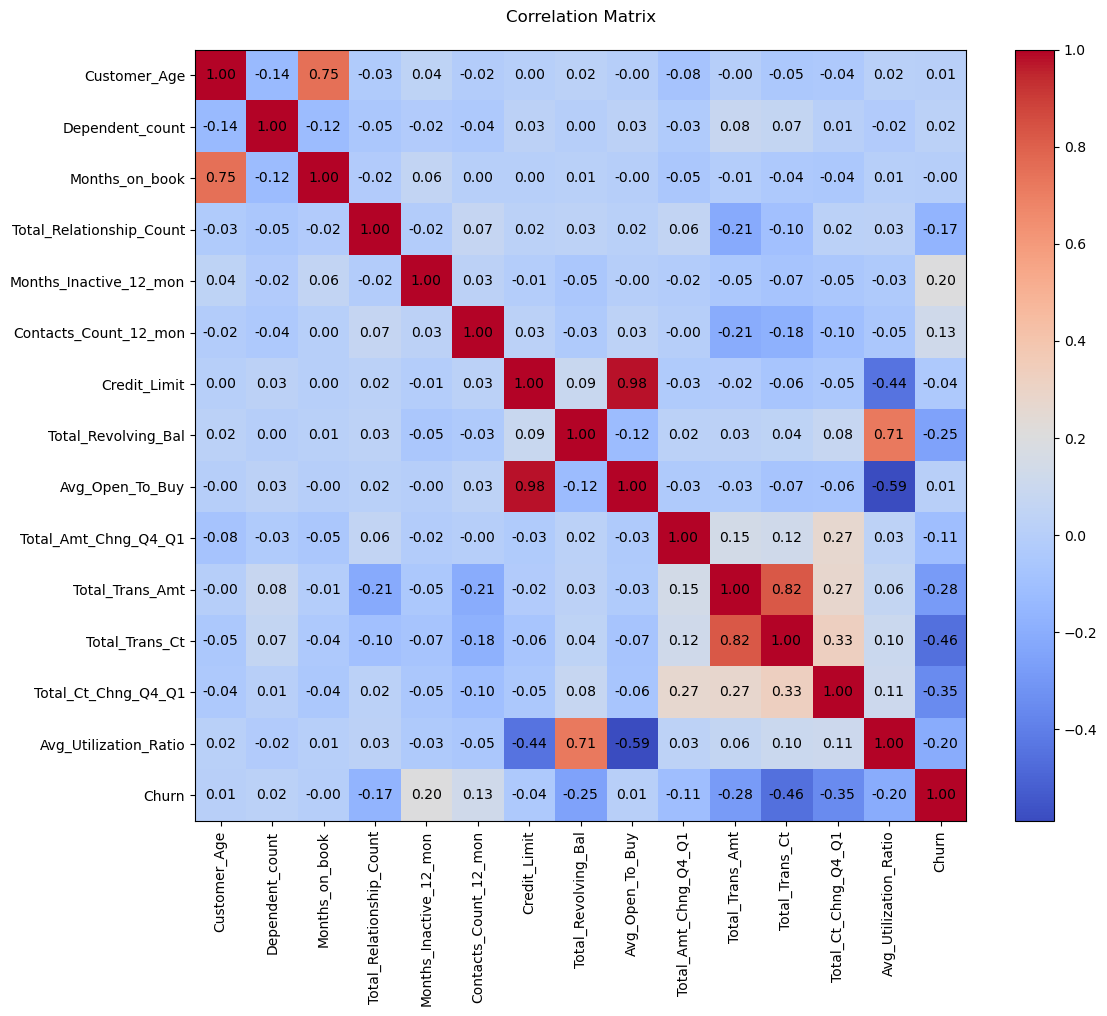

In [ ]:
numeric_features = df.select_dtypes(include=[np.number])
corr_matrix = numeric_features.corr()

print("Correlation Matrix:")
print(corr_matrix)

plt.figure(figsize=(12, 10))
cax = plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar(cax)
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)

# Annotate each cell
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        value = corr_matrix.iloc[i, j]
        plt.text(j, i, f"{value:.2f}", ha="center", va="center", color="black")

plt.title('Correlation Matrix', pad=20)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_classif

# Step 1: Label Encode the categorical columns
label_encoder = LabelEncoder()

# Apply label encoding for each categorical column in the dataset
for column in df.select_dtypes(include=['object']).columns:
    df[column] = label_encoder.fit_transform(df[column])

# Split features and target
X = df.drop(columns=['Churn'])  # Features
y = df['Churn']  # Target

# Step 2: Correlation Coefficient Calculation (Pearson Correlation)
correlation_scores = {}

for feature in X.columns:
    correlation_scores[feature] = X[feature].corr(y)  # Pearson correlation

# Step 3: F-Score (ANOVA F-statistic) Calculation
f_scores, p_values = f_classif(X, y)

# Store the F-scores and their corresponding p-values
f_scores_dict = dict(zip(X.columns, f_scores))

# Step 4: Mutual Information Calculation
mutual_info = mutual_info_classif(X, y)

# Store the mutual information results
mi_scores = dict(zip(X.columns, mutual_info))

# Step 5: Rank the results from highest to lowest
sorted_correlation = sorted(correlation_scores.items(), key=lambda x: abs(x[1]), reverse=True)
sorted_f_scores = sorted(f_scores_dict.items(), key=lambda x: x[1], reverse=True)
sorted_mutual_info = sorted(mi_scores.items(), key=lambda x: x[1], reverse=True)

# Step 6: Print the ranked results

# Print Correlation Coefficients ranked from highest to lowest
print("Correlation Coefficients ranked from highest to lowest:")
for feature, corr in sorted_correlation:
    print(f"{feature}: Correlation = {corr:.4f}")

# Print F-scores ranked from highest to lowest
print("\nF-Scores (ANOVA F-statistic) ranked from highest to lowest:")
for feature, f_score in sorted_f_scores:
    print(f"{feature}: F-Score = {f_score:.4f}")

# Print Mutual Information ranked from highest to lowest
print("\nMutual Information ranked from highest to lowest:")
for feature, mi in sorted_mutual_info:
    print(f"{feature}: Mutual Information = {mi:.4f}")


Correlation Coefficients ranked from highest to lowest:
Attrition_Flag: Correlation = -1.0000
Total_Trans_Ct: Correlation = -0.4569
Total_Ct_Chng_Q4_Q1: Correlation = -0.3511
Total_Trans_Amt: Correlation = -0.2821
Total_Revolving_Bal: Correlation = -0.2500
Avg_Utilization_Ratio: Correlation = -0.2047
Months_Inactive_12_mon: Correlation = 0.2005
Total_Relationship_Count: Correlation = -0.1661
Contacts_Count_12_mon: Correlation = 0.1263
Total_Amt_Chng_Q4_Q1: Correlation = -0.1056
Credit_Limit: Correlation = -0.0405
Gender: Correlation = -0.0373
Dependent_count: Correlation = 0.0243
Income_Category: Correlation = 0.0177
Avg_Open_To_Buy: Correlation = 0.0116
Card_Category: Correlation = -0.0103
Customer_Age: Correlation = 0.0093
Marital_Status: Correlation = 0.0060
Education_Level: Correlation = 0.0035
Months_on_book: Correlation = -0.0007

F-Scores (ANOVA F-statistic) ranked from highest to lowest:
Attrition_Flag: F-Score = inf
Total_Trans_Ct: F-Score = 1704.7922
Total_Ct_Chng_Q4_Q1: F-Sc

### 4.7 Join Plots and Cat Plots


We use Join Plots and Cat Plots to investigate the 

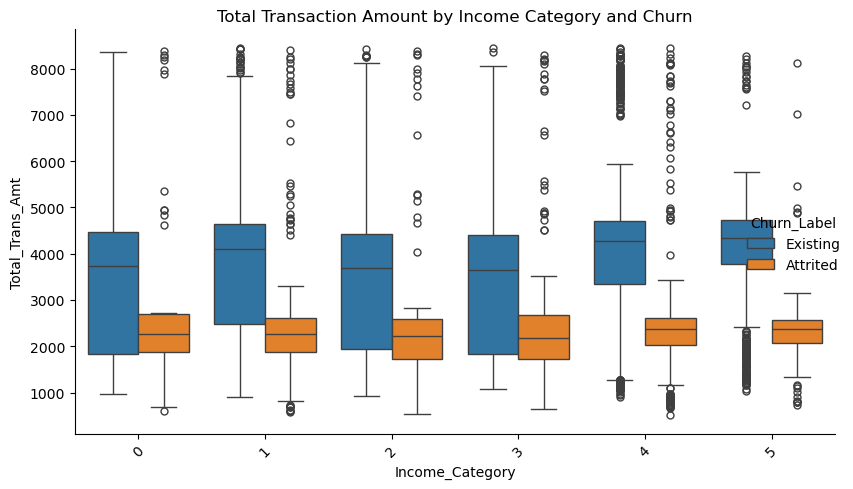

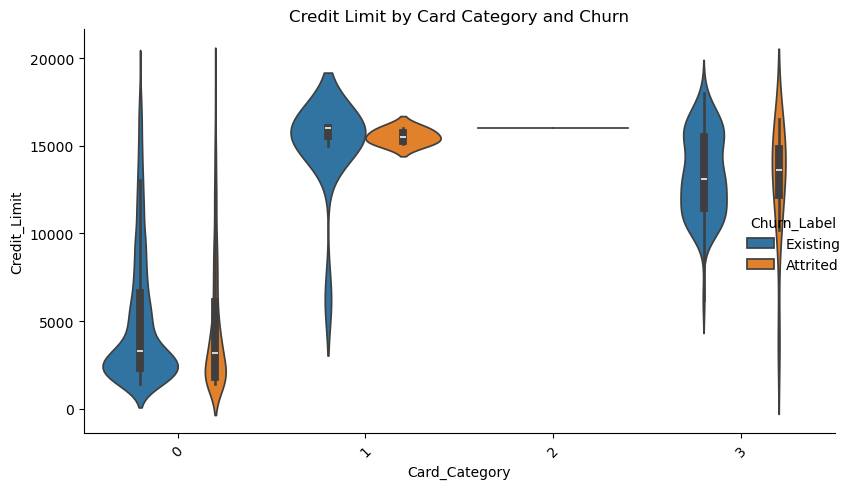

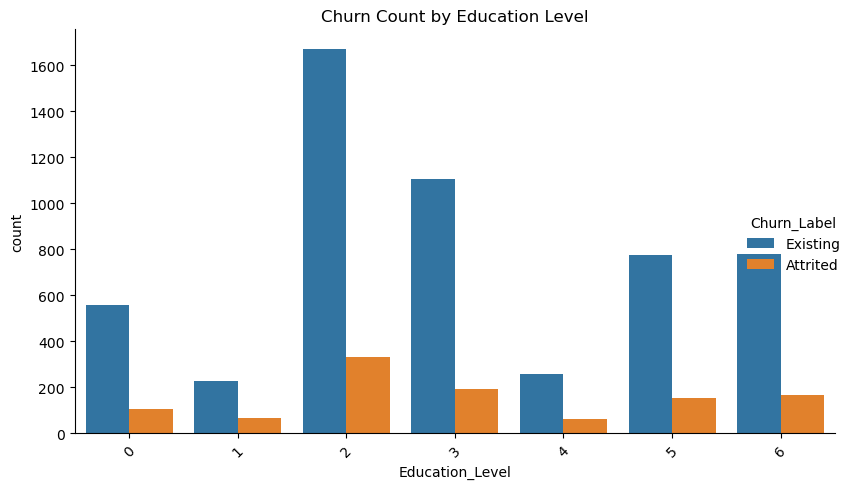

In [ ]:

# Replace 0/1 in 'Churn' with descriptive labels
df['Churn_Label'] = df['Churn'].map({0: 'Existing', 1: 'Attrited'})

# 1. Transaction amount vs Income Category
sns.catplot(data=df, x="Income_Category", y="Total_Trans_Amt", hue="Churn_Label", kind="box", height=5, aspect=1.5)
plt.title("Total Transaction Amount by Income Category and Churn")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Credit Limit by Card Category
sns.catplot(data=df, x="Card_Category", y="Credit_Limit", hue="Churn_Label", kind="violin", height=5, aspect=1.5)
plt.title("Credit Limit by Card Category and Churn")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Count of customers by Education Level and Churn
sns.catplot(data=df, x="Education_Level", hue="Churn_Label", kind="count", height=5, aspect=1.5)
plt.title("Churn Count by Education Level")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


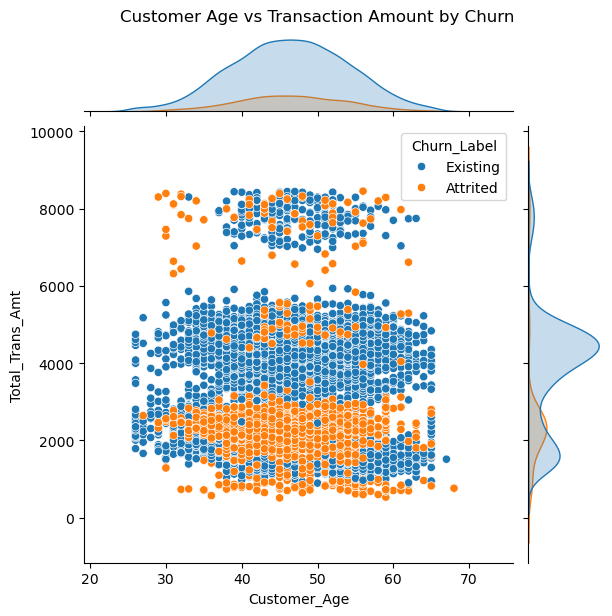

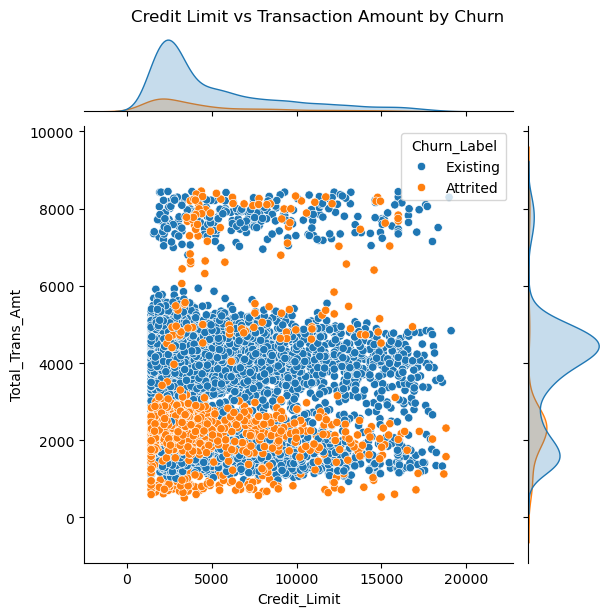

In [ ]:
# Map churn values for clearer labels
df['Churn_Label'] = df['Churn'].map({0: 'Existing', 1: 'Attrited'})

# 1. Customer Age vs Total Transaction Amount
sns.jointplot(data=df, x="Customer_Age", y="Total_Trans_Amt", hue="Churn_Label", kind="scatter", height=6)
plt.suptitle("Customer Age vs Transaction Amount by Churn", y=1.02)
plt.show()

# 2. Credit Limit vs Total Transaction Amount
sns.jointplot(data=df, x="Credit_Limit", y="Total_Trans_Amt", hue="Churn_Label", kind="scatter", height=6)
plt.suptitle("Credit Limit vs Transaction Amount by Churn", y=1.02)
plt.show()


## 5. Predictive Modeling

We build logistic regression, random forest, **XGBoost**, and **AdaBoost** models to predict churn.

### 5.1 Data Preparation for Modeling
We:
- Drop `Attrition_Flag` from the dataset.
- One-hot encode the known categorical columns.
- Define features (`X`) and target (`y`).
- Perform a train-test split.

In [ ]:
!pip install graphviz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay, roc_curve, roc_auc_score,
                             precision_recall_fscore_support)

In [ ]:
import pandas as pd

# Load the CSV
df = pd.read_csv("BankChurners.csv")

# Drop the 'CLIENTNUM' column
df.drop(columns=['CLIENTNUM'], inplace=True)
df.drop(columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1'], inplace=True)
df.drop(columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], inplace=True)

# Select numeric and categorical columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Print unique values for each categorical column
for col in categorical_cols:
    print(f"Unique values in '{col}':")
    print(df[col].unique())
    print("-" * 50)

Unique values in 'Attrition_Flag':
['Existing Customer' 'Attrited Customer']
--------------------------------------------------
Unique values in 'Gender':
['M' 'F']
--------------------------------------------------
Unique values in 'Education_Level':
['High School' 'Graduate' 'Uneducated' 'Unknown' 'College' 'Post-Graduate'
 'Doctorate']
--------------------------------------------------
Unique values in 'Marital_Status':
['Married' 'Single' 'Unknown' 'Divorced']
--------------------------------------------------
Unique values in 'Income_Category':
['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +'
 'Unknown']
--------------------------------------------------
Unique values in 'Card_Category':
['Blue' 'Gold' 'Silver' 'Platinum']
--------------------------------------------------


In [ ]:
cleaned_df = df.copy()
# Drop NA
cleaned_df.dropna()
# Drop duplicates
cleaned_df.drop_duplicates(inplace=True)

# IQR Filtering
for col in numeric_cols:
    Q1 = cleaned_df[col].quantile(0.25)
    Q3 = cleaned_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    IQR_cleaned_df = cleaned_df[(cleaned_df[col] >= lower_bound) & (cleaned_df[col] <= upper_bound)]

# Step 4: Check final shape after removing outliers
print("Cleaned dataset shape:", cleaned_df.shape)

# Optional: Save cleaned data
cleaned_df.to_csv("IQRcleaned_dataset.csv", index=False)
cleaned_df.head

Cleaned dataset shape: (10127, 20)


<bound method NDFrame.head of           Attrition_Flag  Customer_Age Gender  Dependent_count  \
0      Existing Customer            45      M                3   
1      Existing Customer            49      F                5   
2      Existing Customer            51      M                3   
3      Existing Customer            40      F                4   
4      Existing Customer            40      M                3   
...                  ...           ...    ...              ...   
10122  Existing Customer            50      M                2   
10123  Attrited Customer            41      M                2   
10124  Attrited Customer            44      F                1   
10125  Attrited Customer            30      M                2   
10126  Attrited Customer            43      F                2   

      Education_Level Marital_Status Income_Category Card_Category  \
0         High School        Married     $60K - $80K          Blue   
1            Graduate         Single 

### 5.2 Finding the Most Relevant Features

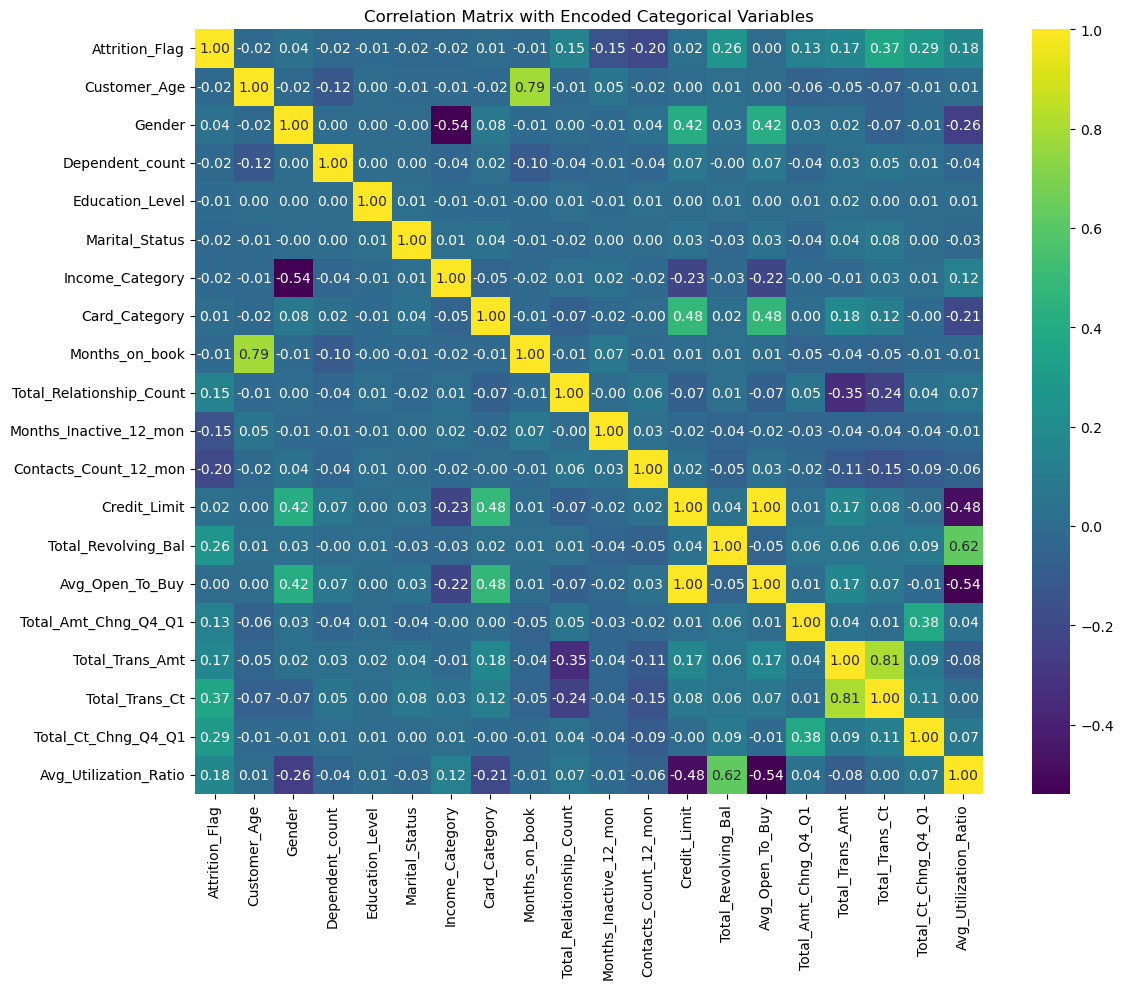

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# List of categorical columns as provided.
categorical_cols = [
    'Attrition_Flag', 
    'Gender', 
    'Education_Level', 
    'Marital_Status', 
    'Income_Category', 
    'Card_Category'
]

# Create a copy of the DataFrame for encoding.
df_encoded = IQR_cleaned_df.copy()

# Apply label encoding to each categorical column.
le = LabelEncoder()
for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Compute the correlation matrix for the entire DataFrame.
corr_matrix = df_encoded.corr()

# Create a heatmap for the correlation matrix.
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='viridis', annot=True, fmt=".2f")
plt.title('Correlation Matrix with Encoded Categorical Variables')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


#### 5.2.2 F-Score

In [ ]:
import pandas as pd
from sklearn.feature_selection import f_classif

# Assume df_encoded is your DataFrame with all features encoded, including "Attrition_Flag".
# Define the target variable.
target = 'Attrition_Flag'

# Create X containing all features except the target variable,
# and y containing the target.
X = df_encoded.drop(columns=[target])
y = df_encoded[target]

# Compute F-scores and p-values using the ANOVA F-test.
F_values, p_values = f_classif(X, y)

# Create a DataFrame to display the F-scores and p-values along with the feature names.
f_scores_df = pd.DataFrame({
    'Feature': X.columns,
    'F_score': F_values,
    'p_value': p_values
}).sort_values(by='F_score', ascending=False)

print("F-scores against Attrition_Flag:")
print(f_scores_df)


F-scores against Attrition_Flag:
                     Feature      F_score        p_value
16            Total_Trans_Ct  1620.121692   0.000000e+00
17       Total_Ct_Chng_Q4_Q1   930.078416  1.647725e-195
12       Total_Revolving_Bal   752.702408  6.630148e-160
10     Contacts_Count_12_mon   441.868050   4.697490e-96
18     Avg_Utilization_Ratio   332.876795   3.357689e-73
15           Total_Trans_Amt   296.227714   1.857439e-65
9     Months_Inactive_12_mon   240.910376   1.032664e-53
8   Total_Relationship_Count   233.072886   4.829281e-52
14      Total_Amt_Chng_Q4_Q1   176.961638   4.836643e-40
1                     Gender    14.085007   1.757076e-04
11              Credit_Limit     5.773729   1.628536e-02
2            Dependent_count     3.652825   5.600239e-02
4             Marital_Status     3.503085   6.128344e-02
0               Customer_Age     3.356074   6.698689e-02
5            Income_Category     3.131546   7.682098e-02
7             Months_on_book     1.897071   1.684370e-0

#### 5.2.3 Mutual Information

In [ ]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif

# Assume df_encoded is your DataFrame with features encoded, including "Attrition_Flag".

# Define the target variable and feature set.
target = 'Attrition_Flag'
X = df_encoded.drop(columns=[target])
y = df_encoded[target]

# Compute the mutual information for each feature with respect to the target.
mi_values = mutual_info_classif(X, y, random_state=42)

# Create a DataFrame to display the mutual information values along with the feature names.
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual_Information': mi_values
}).sort_values(by='Mutual_Information', ascending=False)

print("Mutual Information of each feature with Attrition_Flag:")
print(mi_df)

Mutual Information of each feature with Attrition_Flag:
                     Feature  Mutual_Information
15           Total_Trans_Amt            0.159579
16            Total_Trans_Ct            0.113819
17       Total_Ct_Chng_Q4_Q1            0.097490
12       Total_Revolving_Bal            0.081312
18     Avg_Utilization_Ratio            0.046084
14      Total_Amt_Chng_Q4_Q1            0.028307
10     Contacts_Count_12_mon            0.023935
13           Avg_Open_To_Buy            0.020645
9     Months_Inactive_12_mon            0.017864
8   Total_Relationship_Count            0.013571
11              Credit_Limit            0.009097
3            Education_Level            0.006701
7             Months_on_book            0.005862
4             Marital_Status            0.005622
2            Dependent_count            0.005081
0               Customer_Age            0.002752
1                     Gender            0.002016
6              Card_Category            0.001135
5            

#### 5.2.4 Elbow Plot to Determine Minimum Columns Required

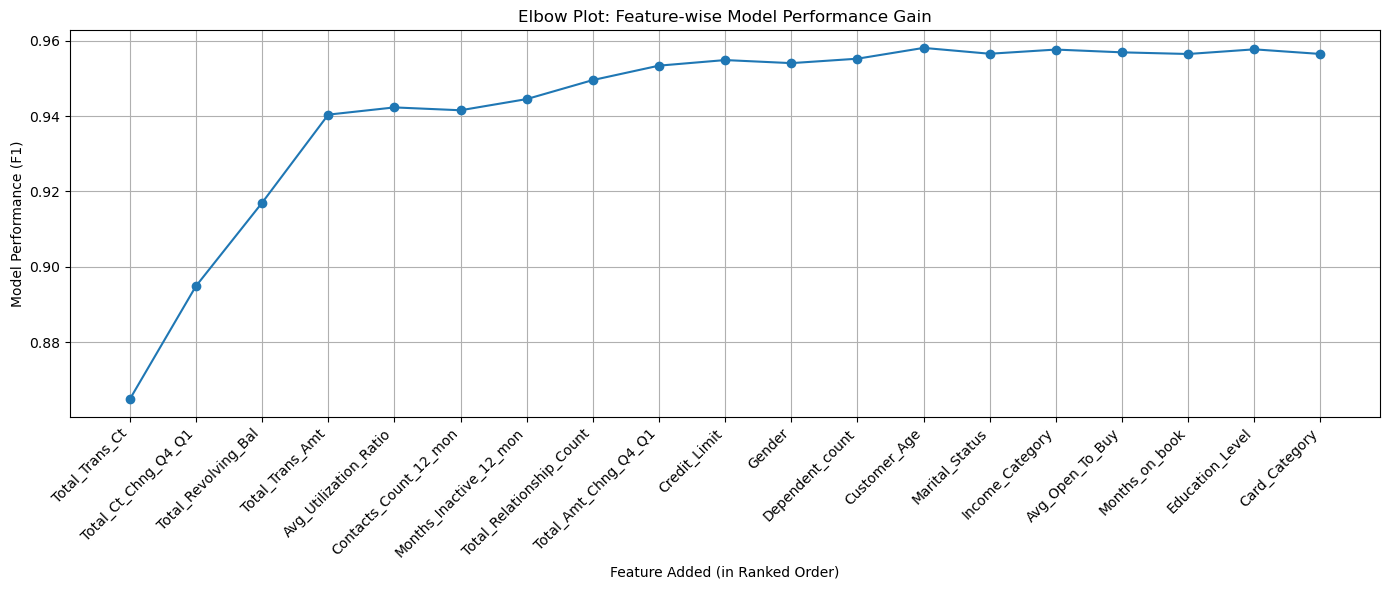

In [79]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier  # or LogisticRegression
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# --- Setup ---
# Your DataFrame with encoded categorical columns and target column
df = df_encoded.copy()
y = df['Attrition_Flag']

# Ranked features from previous combined ranking
ranked_features = [
    'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Total_Revolving_Bal', 'Total_Trans_Amt',
    'Avg_Utilization_Ratio', 'Contacts_Count_12_mon', 'Months_Inactive_12_mon',
    'Total_Relationship_Count', 'Total_Amt_Chng_Q4_Q1', 'Credit_Limit', 'Gender',
    'Dependent_count', 'Customer_Age', 'Marital_Status', 'Income_Category',
    'Avg_Open_To_Buy', 'Months_on_book', 'Education_Level', 'Card_Category'
]

# --- Model and scoring ---
model = RandomForestClassifier(random_state=42)
scoring_metric = 'f1'  # or 'accuracy'

# --- Elbow plot prep ---
scores = []
num_features_list = list(range(1, len(ranked_features) + 1))

for i in num_features_list:
    selected_features = ranked_features[:i]
    X = df[selected_features]
    
    # 5-fold cross-validation
    score = cross_val_score(model, X, y, cv=5, scoring=scoring_metric).mean()
    scores.append(score)

# --- Plot ---
# --- Plot ---
plt.figure(figsize=(14, 6))
plt.plot(num_features_list, scores, marker='o')

# Set x-axis labels to the feature name added at each step
added_features = ranked_features  # Already ordered by importance
plt.xticks(ticks=num_features_list, labels=added_features, rotation=45, ha='right')

plt.title('Elbow Plot: Feature-wise Model Performance Gain')
plt.xlabel('Feature Added (in Ranked Order)')
plt.ylabel(f'Model Performance ({scoring_metric.upper()})')
plt.grid(True)
plt.tight_layout()
plt.show()


## 6 Machine Learning Models

### 6.1 Logistic Regression
Logistic regression estimates the probability of an event occurring, such as voted or didn't vote, based on a given data set of independent variables.

#### Logistic Regression: Attrition_Flag against Total_Trans_Ct

Logistic Regression Results:
Coefficient: 0.05432217053505641
Intercept: -1.3909493448085435
Accuracy: 0.8334
ROC AUC Score: 0.7956
Confusion Matrix:
[[ 134 1493]
 [ 194 8306]]


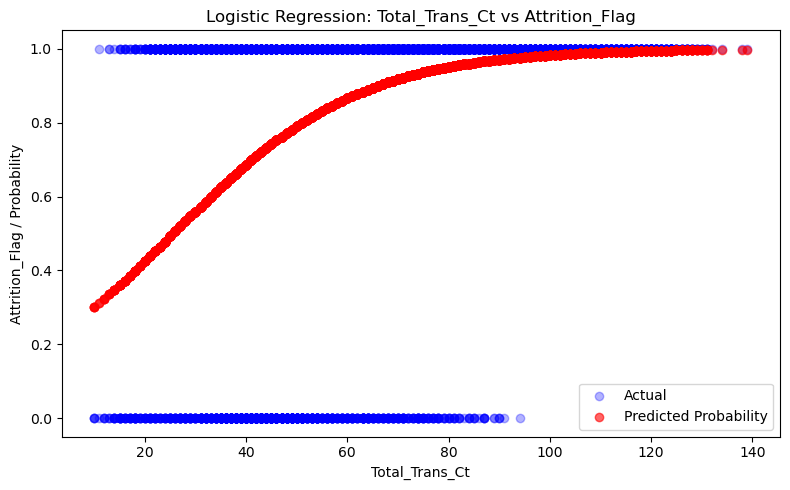

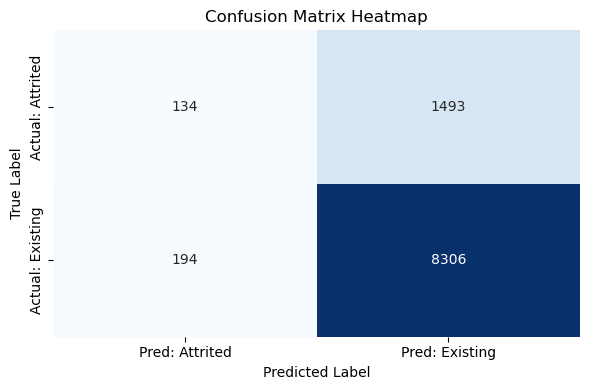

In [80]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define X and y
X = df_encoded[['Total_Trans_Ct']]
y = df_encoded['Attrition_Flag']

# Fit logistic regression
logreg = LogisticRegression()
logreg.fit(X, y)

# Predict class and probabilities
y_pred_class = logreg.predict(X)
y_pred_proba = logreg.predict_proba(X)[:, 1]  # Probability of class 1 (Attrited)

# Evaluation metrics
acc = accuracy_score(y, y_pred_class)
auc = roc_auc_score(y, y_pred_proba)
cm = confusion_matrix(y, y_pred_class)

print("Logistic Regression Results:")
print(f"Coefficient: {logreg.coef_[0][0]}")
print(f"Intercept: {logreg.intercept_[0]}")
print(f"Accuracy: {acc:.4f}")
print(f"ROC AUC Score: {auc:.4f}")
print("Confusion Matrix:")
print(cm)

# --- Visual: Logistic Regression Curve ---
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='blue', alpha=0.3, label='Actual')
plt.scatter(X, y_pred_proba, color='red', alpha=0.6, label='Predicted Probability')
plt.xlabel('Total_Trans_Ct')
plt.ylabel('Attrition_Flag / Probability')
plt.title('Logistic Regression: Total_Trans_Ct vs Attrition_Flag')
plt.legend()
plt.tight_layout()
plt.show()

# --- Visual: Confusion Matrix Heatmap ---
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Attrited', 'Pred: Existing'],
            yticklabels=['Actual: Attrited', 'Actual: Existing'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


#### Logistic Regression: Attrition_Flag against Total_Ct_Chng_Q4_Q1

Logistic Regression Results:
Coefficient: 4.965997692835299
Intercept: -1.5473791155267234
Accuracy: 0.8490
ROC AUC Score: 0.7453
Confusion Matrix:
[[ 187 1440]
 [  89 8411]]


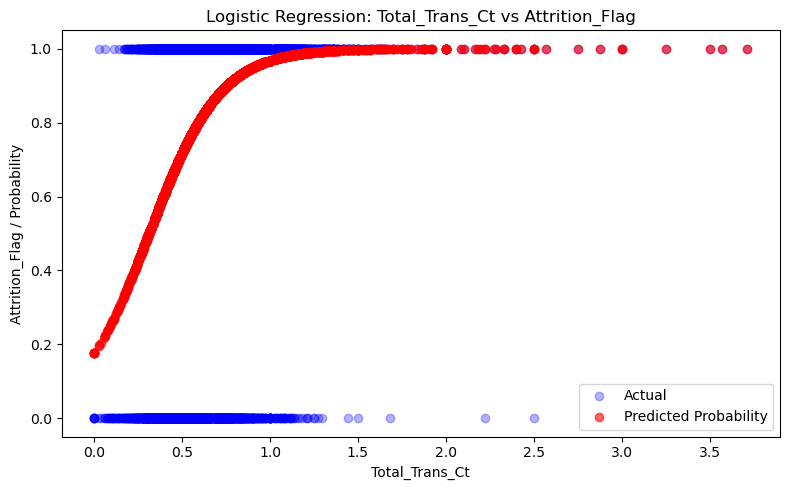

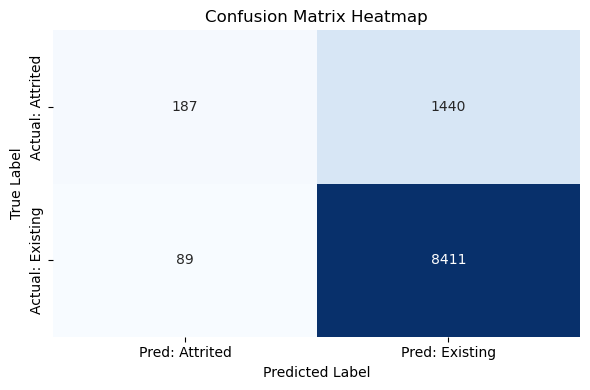

In [81]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define X and y
X = df_encoded[['Total_Ct_Chng_Q4_Q1']]
y = df_encoded['Attrition_Flag']

# Fit logistic regression
logreg = LogisticRegression()
logreg.fit(X, y)

# Predict class and probabilities
y_pred_class = logreg.predict(X)
y_pred_proba = logreg.predict_proba(X)[:, 1]  # Probability of class 1 (Attrited)

# Evaluation metrics
acc = accuracy_score(y, y_pred_class)
auc = roc_auc_score(y, y_pred_proba)
cm = confusion_matrix(y, y_pred_class)

print("Logistic Regression Results:")
print(f"Coefficient: {logreg.coef_[0][0]}")
print(f"Intercept: {logreg.intercept_[0]}")
print(f"Accuracy: {acc:.4f}")
print(f"ROC AUC Score: {auc:.4f}")
print("Confusion Matrix:")
print(cm)

# --- Visual: Logistic Regression Curve ---
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='blue', alpha=0.3, label='Actual')
plt.scatter(X, y_pred_proba, color='red', alpha=0.6, label='Predicted Probability')
plt.xlabel('Total_Trans_Ct')
plt.ylabel('Attrition_Flag / Probability')
plt.title('Logistic Regression: Total_Trans_Ct vs Attrition_Flag')
plt.legend()
plt.tight_layout()
plt.show()

# --- Visual: Confusion Matrix Heatmap ---
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Attrited', 'Pred: Existing'],
            yticklabels=['Actual: Attrited', 'Actual: Existing'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


#### Logistic Regression: Attrition_Flag against Total_Revolving_Bal

Logistic Regression Results:
Coefficient: 0.0009275749206390263
Intercept: 0.7633947274499862
Accuracy: 0.8393
ROC AUC Score: 0.6877
Confusion Matrix:
[[   0 1627]
 [   0 8500]]


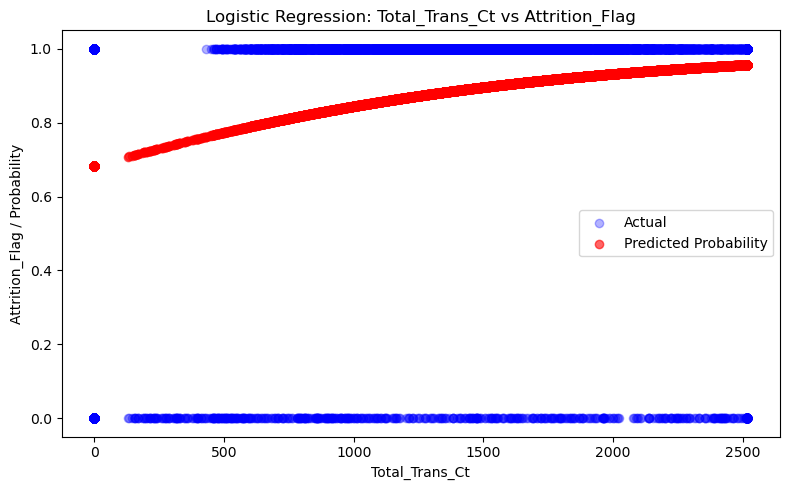

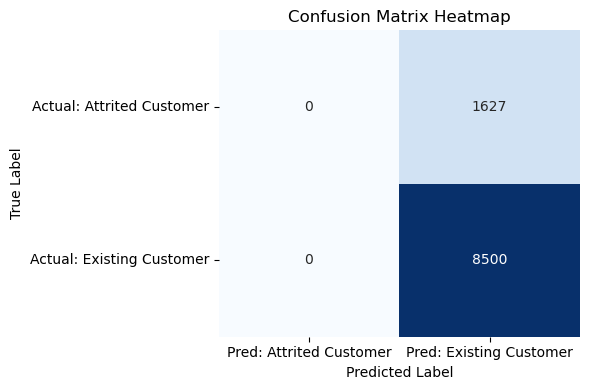

In [82]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define X and y
X = df_encoded[['Total_Revolving_Bal']]
y = df_encoded['Attrition_Flag']

# Fit logistic regression
logreg = LogisticRegression()
logreg.fit(X, y)

# Predict class and probabilities
y_pred_class = logreg.predict(X)
y_pred_proba = logreg.predict_proba(X)[:, 1]  # Probability of class 1 (Attrited)

# Evaluation metrics
acc = accuracy_score(y, y_pred_class)
auc = roc_auc_score(y, y_pred_proba)
cm = confusion_matrix(y, y_pred_class)

print("Logistic Regression Results:")
print(f"Coefficient: {logreg.coef_[0][0]}")
print(f"Intercept: {logreg.intercept_[0]}")
print(f"Accuracy: {acc:.4f}")
print(f"ROC AUC Score: {auc:.4f}")
print("Confusion Matrix:")
print(cm)

# --- Visual: Logistic Regression Curve ---
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='blue', alpha=0.3, label='Actual')
plt.scatter(X, y_pred_proba, color='red', alpha=0.6, label='Predicted Probability')
plt.xlabel('Total_Trans_Ct')
plt.ylabel('Attrition_Flag / Probability')
plt.title('Logistic Regression: Total_Trans_Ct vs Attrition_Flag')
plt.legend()
plt.tight_layout()
plt.show()

# --- Visual: Confusion Matrix Heatmap ---
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Attrited Customer', 'Pred: Existing Customer'],
            yticklabels=['Actual: Attrited Customer', 'Actual: Existing Customer'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

#### Logistic Regression: Attrition_Flag against Total_Trans_Amt

Logistic Regression Results:
Coefficient: 0.00024092367759846606
Intercept: 0.7639090174091386
Accuracy: 0.8393
ROC AUC Score: 0.6759
Confusion Matrix:
[[   0 1627]
 [   0 8500]]


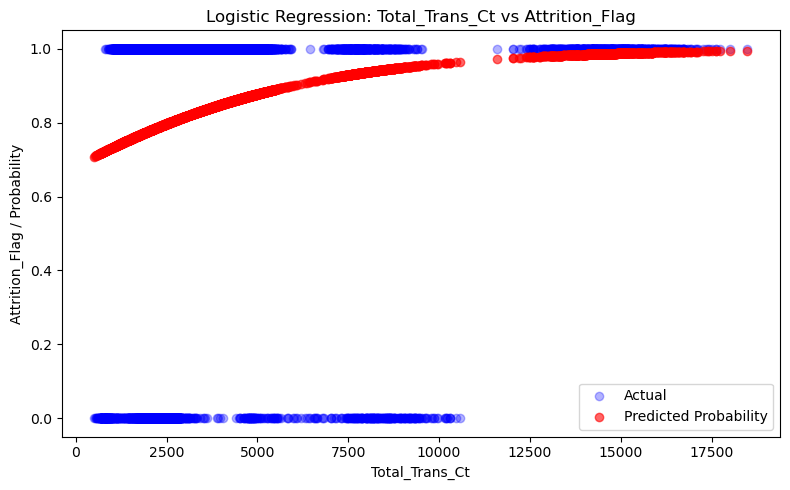

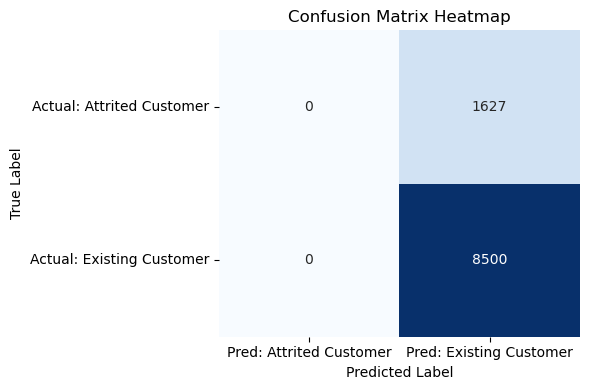

In [83]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define X and y
X = df_encoded[['Total_Trans_Amt']]
y = df_encoded['Attrition_Flag']

# Fit logistic regression
logreg = LogisticRegression()
logreg.fit(X, y)

# Predict class and probabilities
y_pred_class = logreg.predict(X)
y_pred_proba = logreg.predict_proba(X)[:, 1]  # Probability of class 1 (Attrited)

# Evaluation metrics
acc = accuracy_score(y, y_pred_class)
auc = roc_auc_score(y, y_pred_proba)
cm = confusion_matrix(y, y_pred_class)

print("Logistic Regression Results:")
print(f"Coefficient: {logreg.coef_[0][0]}")
print(f"Intercept: {logreg.intercept_[0]}")
print(f"Accuracy: {acc:.4f}")
print(f"ROC AUC Score: {auc:.4f}")
print("Confusion Matrix:")
print(cm)

# --- Visual: Logistic Regression Curve ---
plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='blue', alpha=0.3, label='Actual')
plt.scatter(X, y_pred_proba, color='red', alpha=0.6, label='Predicted Probability')
plt.xlabel('Total_Trans_Ct')
plt.ylabel('Attrition_Flag / Probability')
plt.title('Logistic Regression: Total_Trans_Ct vs Attrition_Flag')
plt.legend()
plt.tight_layout()
plt.show()

# --- Visual: Confusion Matrix Heatmap ---
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Attrited Customer', 'Pred: Existing Customer'],
            yticklabels=['Actual: Attrited Customer', 'Actual: Existing Customer'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

#### Logistic Regression: Attrition_Flag against df_encoded[['Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Total_Revolving_Bal', 'Total_Trans_Amt']]

In view of the low accuracy and performance of single variables, we decided to use a multivariate feature to predict Attrition_Flag

Logistic Regression Results:
Coefficient for Total_Trans_Ct: 0.1040
Coefficient for Total_Ct_Chng_Q4_Q1: 3.0909
Coefficient for Total_Revolving_Bal: 0.0010
Coefficient for Total_Trans_Amt: -0.0005
Intercept: -5.4061
Accuracy: 0.8851
ROC AUC Score: 0.8938
Confusion Matrix:
[[ 805  822]
 [ 342 8158]]


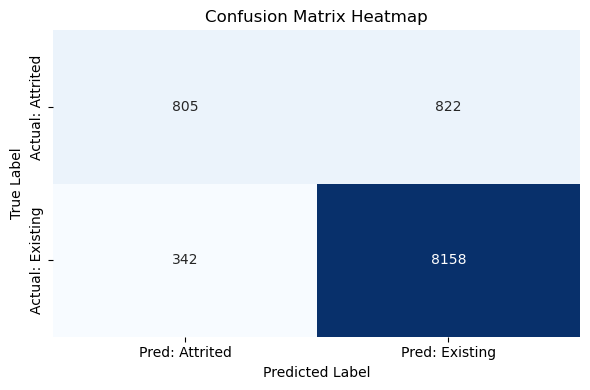

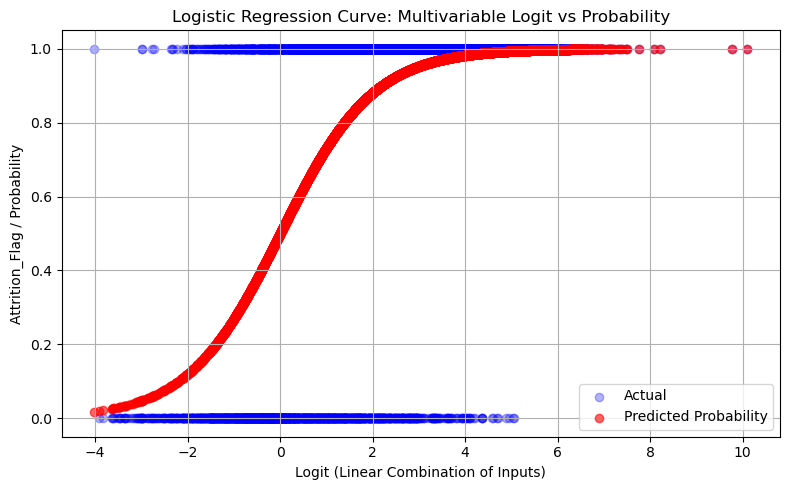

In [84]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define X and y with 4 top-ranked features
X = df_encoded[['Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Total_Revolving_Bal', 'Total_Trans_Amt']]
y = df_encoded['Attrition_Flag']

# Fit logistic regression
logreg = LogisticRegression(max_iter=1000)  # Increase max_iter for convergence
logreg.fit(X, y)

# Predict class and probabilities
y_pred_class = logreg.predict(X)
y_pred_proba = logreg.predict_proba(X)[:, 1]  # Probability of class 1 (Attrited)

# Evaluation metrics
acc = accuracy_score(y, y_pred_class)
auc = roc_auc_score(y, y_pred_proba)
cm = confusion_matrix(y, y_pred_class)

print("Logistic Regression Results:")
for i, feature in enumerate(X.columns):
    print(f"Coefficient for {feature}: {logreg.coef_[0][i]:.4f}")
print(f"Intercept: {logreg.intercept_[0]:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"ROC AUC Score: {auc:.4f}")
print("Confusion Matrix:")
print(cm)

# --- Visual: Confusion Matrix Heatmap ---
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Attrited', 'Pred: Existing'],
            yticklabels=['Actual: Attrited', 'Actual: Existing'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Compute linear combination (logit) manually
logit_values = np.dot(X, logreg.coef_[0]) + logreg.intercept_[0]

# Plot the sigmoid curve
plt.figure(figsize=(8, 5))
plt.scatter(logit_values, y, color='blue', alpha=0.3, label='Actual')
plt.scatter(logit_values, y_pred_proba, color='red', alpha=0.6, label='Predicted Probability')
plt.xlabel('Logit (Linear Combination of Inputs)')
plt.ylabel('Attrition_Flag / Probability')
plt.title('Logistic Regression Curve: Multivariable Logit vs Probability')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 6.2 Decision Trees

Decision Tree Classifier Results:
Accuracy: 0.9275
ROC AUC Score: 0.9476
Confusion Matrix:
[[1247  380]
 [ 354 8146]]


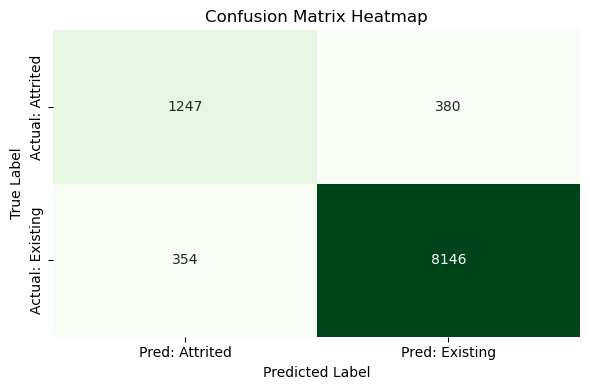

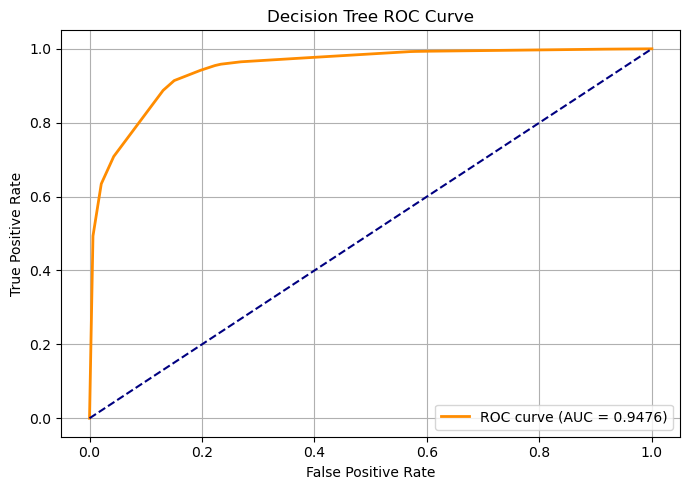

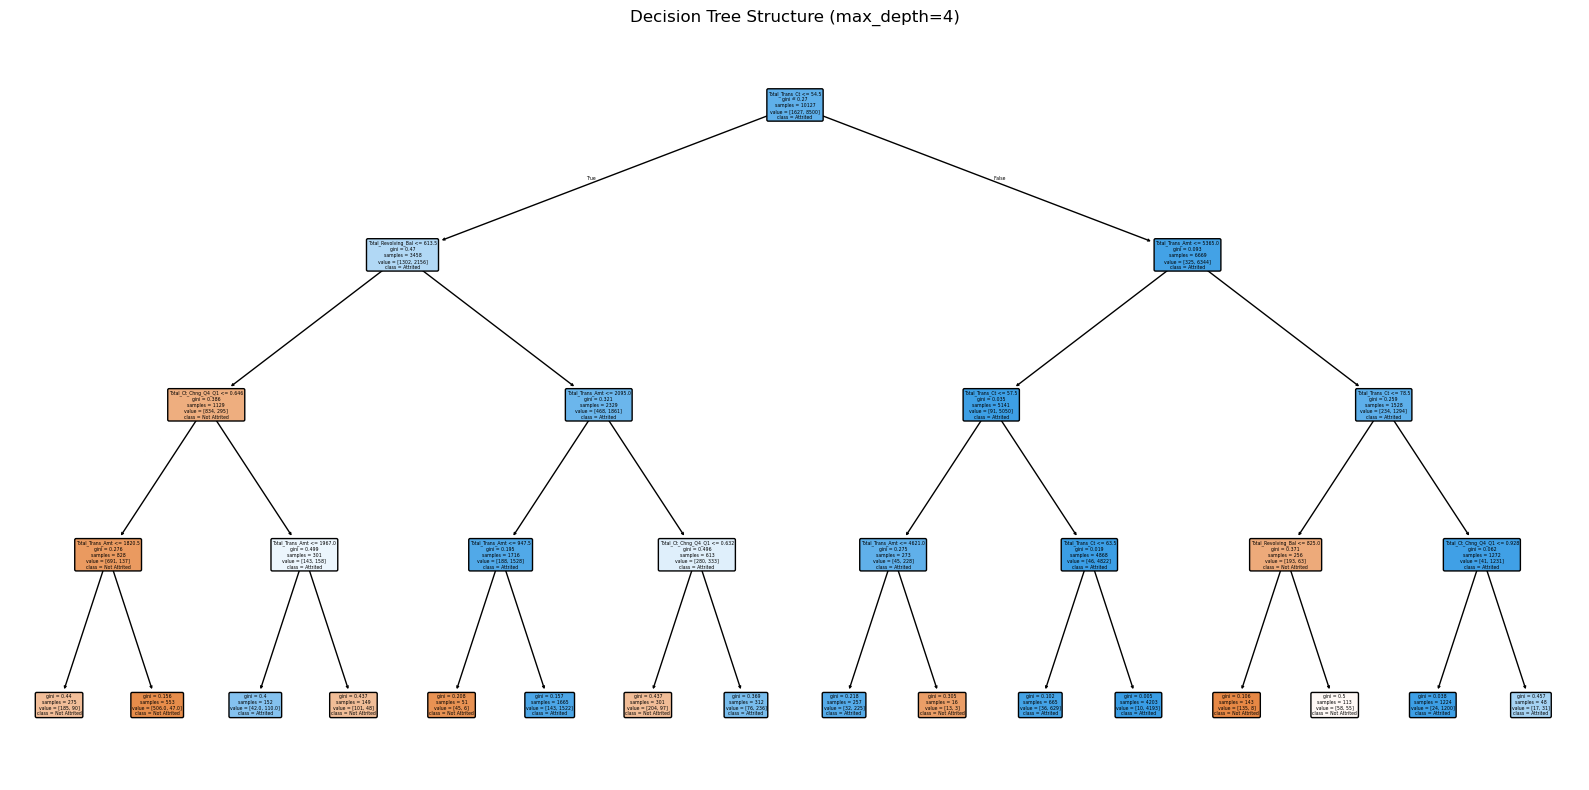

In [85]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Define X and y with top 4 features
X = df_encoded[['Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Total_Revolving_Bal', 'Total_Trans_Amt']]
y = df_encoded['Attrition_Flag']

# Fit Decision Tree Classifier
tree_clf = DecisionTreeClassifier(max_depth=4, random_state=42)  # You can tweak max_depth
tree_clf.fit(X, y)

# Predictions
y_pred_class = tree_clf.predict(X)
y_pred_proba = tree_clf.predict_proba(X)[:, 1]

# Evaluation metrics
acc = accuracy_score(y, y_pred_class)
auc_score = roc_auc_score(y, y_pred_proba)
cm = confusion_matrix(y, y_pred_class)

print("Decision Tree Classifier Results:")
print(f"Accuracy: {acc:.4f}")
print(f"ROC AUC Score: {auc_score:.4f}")
print("Confusion Matrix:")
print(cm)

# --- Visual: Confusion Matrix Heatmap ---
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Pred: Attrited', 'Pred: Existing'],
            yticklabels=['Actual: Attrited', 'Actual: Existing'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# --- Visual: ROC Curve ---
fpr, tpr, _ = roc_curve(y, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Visual: Decision Tree Structure ---
plt.figure(figsize=(16, 8))
plot_tree(tree_clf, feature_names=X.columns, class_names=['Not Attrited', 'Attrited'],
          filled=True, rounded=True)
plt.title("Decision Tree Structure (max_depth=4)")
plt.tight_layout()
plt.show()


### 6.3 Bagging of Trees: Random Forest
Random forest uses multiple decision trees to make predictions, improving accuracy and reducing overfitting.

Random Forest Classifier Results:
Accuracy: 0.9370
ROC AUC Score: 0.9747
Confusion Matrix:
[[1176  451]
 [ 187 8313]]


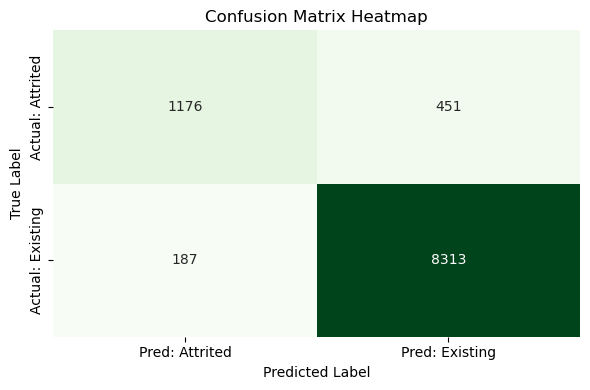

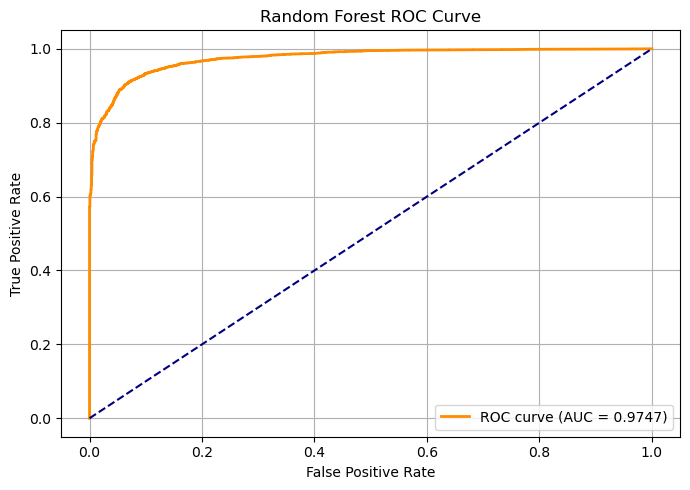

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import seaborn as sns

# Define X and y
X = df_encoded[['Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Total_Revolving_Bal', 'Total_Trans_Amt']]
y = df_encoded['Attrition_Flag']

# Fit Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf_clf.fit(X, y)

# Predictions
y_pred_class = rf_clf.predict(X)
y_pred_proba = rf_clf.predict_proba(X)[:, 1]

# Evaluation metrics
acc = accuracy_score(y, y_pred_class)
auc_score = roc_auc_score(y, y_pred_proba)
cm = confusion_matrix(y, y_pred_class)

print("Random Forest Classifier Results:")
print(f"Accuracy: {acc:.4f}")
print(f"ROC AUC Score: {auc_score:.4f}")
print("Confusion Matrix:")
print(cm)

# --- Visual: Confusion Matrix Heatmap ---
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=['Pred: Attrited', 'Pred: Existing'],
            yticklabels=['Actual: Attrited', 'Actual: Existing'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# --- Visual: ROC Curve ---
fpr, tpr, _ = roc_curve(y, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Visual: Feature Importances ---
importances = rf_clf.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(160, 80), dpi=200)
sns.barplot(x=importances[indices], y=features[indices], palette='magma')
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# --- Visual: One Tree from the Random Forest ---
plt.figure(figsize=(20, 10))
plot_tree(rf_clf.estimators_[0],  # Plot the first tree in the forest
          feature_names=X.columns,
          class_names=['Not Attrited', 'Attrited'],
          filled=True, rounded=True, fontsize=8, )
plt.title("Example Tree from Random Forest")
plt.tight_layout()
plt.show()



### 6.4 Boosting of Trees: AdaBoost
AdaBoost is an ensemble machine learning method that combines multiple weak learners to create a strong classifier or regressor. It works by iteratively training a sequence of models, where each new model focuses on instances incorrectly classified by previous models.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

# --- Define X and y ---
X = df_encoded[['Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Total_Revolving_Bal', 'Total_Trans_Amt']]
y = df_encoded['Attrition_Flag']

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# --- Fit AdaBoost ---
ada_clf = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_clf.fit(X_train, y_train)

# --- Predictions ---
y_pred = ada_clf.predict(X_test)
y_proba = ada_clf.predict_proba(X_test)[:, 1]

# --- Evaluation Metrics ---
acc = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

print("=== AdaBoost Classifier Results ===")
print(f"Accuracy: {acc:.4f}")
print(f"ROC AUC Score: {auc_score:.4f}")
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Confusion Matrix Heatmap ---
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['Pred: Existing', 'Pred: Attrited'],
            yticklabels=['Actual: Existing', 'Actual: Attrited'])
plt.title('AdaBoost: Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'AdaBoost ROC Curve (AUC = {roc_auc:.4f})', color='crimson')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AdaBoost ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Feature Importances ---
if hasattr(ada_clf, 'feature_importances_'):
    importances = ada_clf.feature_importances_
    feature_names = X.columns
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(8, 5))
    sns.barplot(x=importances[indices], y=feature_names[indices], palette='magma')
    plt.title("AdaBoost Feature Importances")
    plt.xlabel("Importance Score")
    plt.tight_layout()
    plt.show()
else:
    print("AdaBoost base estimator does not expose feature_importances_.")


### 6.5 Boosting of Trees: XGBoost

XGBoost, short for Extreme Gradient Boosting, is a popular and powerful open-source machine learning library used for both classification and regression tasks.

Compared to AdaBoost, XGBoost is a more complex algorithm that uses gradient descent to optimize the loss function

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define X and y ---
X = df_encoded[['Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Total_Revolving_Bal', 'Total_Trans_Amt']]
y = df_encoded['Attrition_Flag']

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# --- Fit XGBoost Classifier ---
xgb_clf = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_clf.fit(X_train, y_train)

# --- Predictions ---
y_pred = xgb_clf.predict(X_test)
y_proba = xgb_clf.predict_proba(X_test)[:, 1]

# --- Evaluation ---
acc = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

print("=== XGBoost Classifier Results ===")
print(f"Accuracy: {acc:.4f}")
print(f"ROC AUC Score: {auc_score:.4f}")
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- Confusion Matrix Heatmap ---
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False,
            xticklabels=['Pred: Existing', 'Pred: Attrited'],
            yticklabels=['Actual: Existing', 'Actual: Attrited'])
plt.title('XGBoost: Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost: ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Feature Importances ---
importances = xgb_clf.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
sns.barplot(x=importances[indices], y=features[indices], palette='viridis')
plt.title("XGBoost Feature Importances")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


### 6.6 Support Vector Machines (3-Dimensional)
A Support Vector Machine (SVM) is a supervised learning algorithm that can be used for classification and regression tasks. 

It finds the best hyperplane to separate different classes of data points, maximizing the distance between the hyperplane and the closest data points of each class.

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.preprocessing import StandardScaler

# --- Define X and y ---
X = df_encoded[['Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Total_Revolving_Bal']]
y = df_encoded['Attrition_Flag']

# --- Standardize Features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Train SVM with linear kernel ---
svm_clf = SVC(kernel='linear', random_state=42)
svm_clf.fit(X_scaled, y)

# --- Predict ---
y_pred = svm_clf.predict(X_scaled)

# --- Prepare DataFrame for Visualisation ---
X_3d = pd.DataFrame(X_scaled, columns=X.columns)
X_3d['Actual'] = y.values
X_3d['Predicted'] = y_pred

# --- Classification Outcome Tagging ---
def get_outcome(row):
    if row['Actual'] == 0 and row['Predicted'] == 0:
        return 'True Existing'
    elif row['Actual'] == 1 and row['Predicted'] == 1:
        return 'True Attrited'
    elif row['Actual'] == 1 and row['Predicted'] == 0:
        return 'False Existing'
    else:
        return 'False Attrited'

X_3d['Outcome'] = X_3d.apply(get_outcome, axis=1)

# --- Confusion Matrix Heatmap ---
cm = confusion_matrix(X_3d['Actual'], X_3d['Predicted'])
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='YlOrRd', cbar=False,
    xticklabels=['Predicted Existing', 'Predicted Attrited'],
    yticklabels=['Actual Existing', 'Actual Attrited']
)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.tight_layout()
plt.show()

# --- 3D Scatter Plot ---
color_map = {
    'True Attrited': 'green',
    'True Existing': 'red',
    'False Attrited': 'yellow',
    'False Existing': 'orange'
}

scatter = go.Scatter3d(
    x=X_3d['Total_Trans_Ct'],
    y=X_3d['Total_Ct_Chng_Q4_Q1'],
    z=X_3d['Total_Revolving_Bal'],
    mode='markers',
    marker=dict(
        size=5,
        color=[color_map[o] for o in X_3d['Outcome']],
        opacity=0.7
    ),
    text=X_3d['Outcome'],
    name='Classification Outcome'
)

# --- SVM Decision Hyperplane ---
x_range = np.linspace(X_3d['Total_Trans_Ct'].min(), X_3d['Total_Trans_Ct'].max(), 10)
y_range = np.linspace(X_3d['Total_Ct_Chng_Q4_Q1'].min(), X_3d['Total_Ct_Chng_Q4_Q1'].max(), 10)
xx, yy = np.meshgrid(x_range, y_range)

coef = svm_clf.coef_[0]
intercept = svm_clf.intercept_[0]
zz = (-coef[0] * xx - coef[1] * yy - intercept) / coef[2]

plane = go.Surface(
    x=xx, y=yy, z=zz,
    showscale=False,
    opacity=0.3,
    colorscale=[[0, 'red'], [1, 'red']],
    name='SVM Hyperplane'
)

# --- Combine & Render Plot ---
fig = go.Figure(data=[scatter, plane])
fig.update_layout(
    title='SVM Classification Outcome in 3D Feature Space<br><sub>Green: True Attrited | Red: True Existing | Yellow: False Attrited | Orange: False Existing</sub>',
    scene=dict(
        xaxis_title='Total_Trans_Ct',
        yaxis_title='Total_Ct_Chng_Q4_Q1',
        zaxis_title='Total_Revolving_Bal'
    ),
    width=1000,
    height=800,
    legend_title_text='Prediction Outcome',
    margin=dict(l=20, r=20, b=20, t=80)
)
fig.write_html("svm_3d_colored_outcome_with_heatmap.html")
fig.show()

# --- Evaluation Metrics ---
accuracy = accuracy_score(X_3d['Actual'], X_3d['Predicted'])
precision = precision_score(X_3d['Actual'], X_3d['Predicted'])
recall = recall_score(X_3d['Actual'], X_3d['Predicted'])
f1 = f1_score(X_3d['Actual'], X_3d['Predicted'])

print("SVM Performance Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")


### 6.7 Support Vector Machine (with dimensionality reduction using PCA)
Due to the poor performance of the 3D SVM, we decided to try Dimensionality Reduction with PCA first, before performing SVM again.

Indeed, it showed much better performance than the 3D SVM.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# --- Define X and y ---
X = df_encoded[['Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Total_Revolving_Bal', 'Total_Trans_Amt']]
y = df_encoded['Attrition_Flag']

# --- Standardize features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Fit Support Vector Machine ---
svm_clf = SVC(kernel='rbf', probability=True, random_state=42)
svm_clf.fit(X_scaled, y)

# --- Predict ---
y_pred_class = svm_clf.predict(X_scaled)
y_pred_proba = svm_clf.predict_proba(X_scaled)[:, 1]

# --- Evaluation ---
acc = accuracy_score(y, y_pred_class)
auc_score = roc_auc_score(y, y_pred_proba)
cm = confusion_matrix(y, y_pred_class)

print("SVM Classifier Results:")
print(f"Accuracy: {acc:.4f}")
print(f"ROC AUC Score: {auc_score:.4f}")
print("Confusion Matrix:")
print(cm)

# --- Confusion Matrix Heatmap ---
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=['Pred: Attrited', 'Pred: Existing'],
            yticklabels=['Actual: Attrited', 'Actual: Existing'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# --- ROC Curve ---
fpr, tpr, _ = roc_curve(y, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='purple', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- PCA Reduction for 2D Plot ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Refit SVM on PCA space for decision boundary visualization
svm_pca_clf = SVC(kernel='rbf', probability=True)
svm_pca_clf.fit(X_pca, y)

# --- Decision boundary plot in 2D (PCA) ---
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
Z = svm_pca_clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='Set1', edgecolor='k')
plt.title('SVM Decision Regions (PCA-reduced 2D space)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Attrition_Flag')
plt.tight_layout()
plt.show()


### 6.8 Neural Network (MLPClassifier)
Lastly, We decided to try using a Neural Network to predict Attrition Rate.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, auc, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define X and y
X = df_encoded[['Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Total_Revolving_Bal', 'Total_Trans_Amt']]
y = df_encoded['Attrition_Flag']

# --- Step 1: Standardize features for neural networks ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Step 2: Define and train the neural network ---
mlp = MLPClassifier(hidden_layer_sizes=(16, 8), activation='relu', solver='adam',
                    max_iter=500, random_state=42)
mlp.fit(X_scaled, y)

# --- Step 3: Predictions ---
y_pred_class = mlp.predict(X_scaled)
y_pred_proba = mlp.predict_proba(X_scaled)[:, 1]

# --- Step 4: Evaluation metrics ---
acc = accuracy_score(y, y_pred_class)
auc_score = roc_auc_score(y, y_pred_proba)
f1 = f1_score(y, y_pred_class)
cm = confusion_matrix(y, y_pred_class)

print("Neural Network (MLPClassifier) Results:")
print(f"Accuracy: {acc:.4f}")
print(f"ROC AUC Score: {auc_score:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)

# --- Step 5: Heatmap of Confusion Matrix ---
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Attrited', 'Pred: Existing'],
            yticklabels=['Actual: Attrited', 'Actual: Existing'])
plt.title('Confusion Matrix Heatmap (Neural Net)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# --- Step 6: ROC Curve ---
fpr, tpr, _ = roc_curve(y, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Neural Network)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


## Conclusion

Our study delivered the following key takeaways:

- **Top churn drivers**:  
  1. **Total_Trans_Ct** (highest correlation & F‑score)  
  2. **Total_Trans_Amt** (highest mutual information)  
  3. **Avg_Utilization_Ratio**, **Total_Revolving_Bal**, **Contacts_Count_12_mon**.

- **Model performance**:  
  - **XGBoost** led with **94.90% accuracy** and **F1 0.8323**.  
  - **MLP Classifier** close behind at **94.48% accuracy** and **F1 0.8288**.  
  - SVM (with PCA) and Random Forest also delivered strong results (~ 92–93% accuracy).

- **Recommended actions**:  
  1. **Educational workshops** on account usage & budgeting.  
  2. **Credit‑rebuilding programmes** for high‑utilisation customers.  
  3. **Personalised retention perks** (cashback, loyalty bonuses).  
  4. **Early‑warning alerts** for at‑risk segments identified via clustering.

By integrating deep EDA, robust feature ranking, and ensemble modelling, this framework equips banking teams to **anticipate** and **mitigate** churn—preserving revenue and strengthening customer loyalty.  







